## Dataclass and Dataset loader class
#### both work to get the data in batches and here some transformation before to batch can also be applied
#### example : (CNN - augmentation,ANN-sampling)

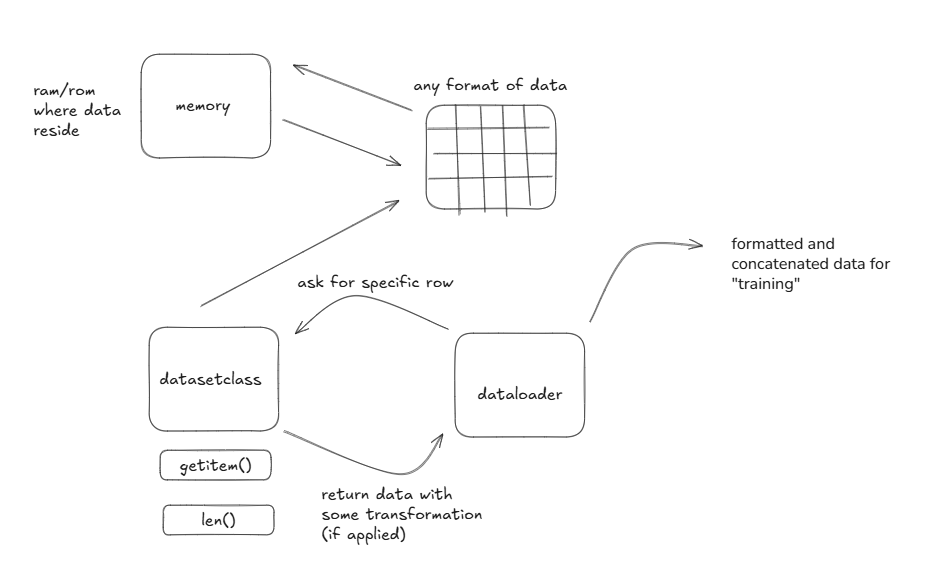

In [1]:
import torch
from torch.utils.data import Dataset,DataLoader
import pandas as pd
import numpy as np
import torch.nn as nn
from torchinfo import summary
from sklearn.preprocessing import StandardScaler,LabelEncoder
from sklearn.model_selection import train_test_split

In [2]:
path = "/content/diabetes.csv"
df = pd.read_csv(path)
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [3]:
# data split
X = df.drop(columns=['Outcome'])
y = df['Outcome']
## train test split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2)

In [4]:
## preprocessing the data
scaler = StandardScaler()
encoder = LabelEncoder()
# X
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
# y
y_train = encoder.fit_transform(y_train)
y_test = encoder.transform(y_test)

In [5]:
## converting to tensor
X_train = torch.tensor(X_train,dtype=torch.float32)
X_test = torch.tensor(X_test,dtype=torch.float32)
y_train = torch.tensor(y_train,dtype=torch.float32)
y_test = torch.tensor(y_test,dtype=torch.float32)

In [6]:
## dataset class
class CustomDataset(Dataset):
  def __init__(self,X,y): #inital operation in dataloading
    self.X = X
    self.y = y
  def __len__(self): # get the length of data
    return self.X.shape[0]
  def __getitem__(self,idx):# to get any provided item
    return self.X[idx],self.y[idx]

In [7]:
train_tensor = CustomDataset(X_train,y_train)
test_tensor = CustomDataset(X_test,y_test)

In [23]:
train_tensor

In [9]:
train_tensor[10] # getitem

(tensor([ 0.9590, -0.7617,  0.3600,  0.7033,  0.1437,  1.1091,  1.2578, -0.0814]),
 tensor(1.))

In [10]:
len(train_tensor)

614

In [11]:
## dataloader class
train_loader = DataLoader(train_tensor,batch_size=32,shuffle=True)
test_loader = DataLoader(test_tensor,batch_size=32,shuffle=True)

In [12]:
## lets build model

class diabetes_prediction(nn.Module):
  def __init__(self,in_feature):
    super().__init__()
    self.network = nn.Sequential(
        nn.Linear(in_feature,5),
        nn.ReLU(),
        nn.Linear(5,3),
        nn.ReLU(),
        nn.Linear(3,1),
        nn.Sigmoid()
    )
  def forward(self,X):
    return self.network(X)

In [13]:
## building the loss
loss_function = nn.BCELoss()

In [14]:
learning_rate = 0.07
epochs = 35

In [15]:
## Building the models
model = diabetes_prediction(X_train.shape[1])
model(X_train)
## building the optimizer
optimizer = torch.optim.SGD(model.parameters(),lr=learning_rate)

## Training

In [16]:
for epoch in range(epochs):
  loss = 0
  for feature,label in train_loader:
    y_pred = model(feature)
    loss = loss_function(y_pred,label.view(-1,1))
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

  #break
  print(f"epoch:{epoch+1} | loss:{loss}")

epoch:1 | loss:0.7134428024291992
epoch:2 | loss:0.5626575350761414
epoch:3 | loss:0.5479034781455994
epoch:4 | loss:0.6114668250083923
epoch:5 | loss:0.6314974427223206
epoch:6 | loss:0.7401944994926453
epoch:7 | loss:0.7400810122489929
epoch:8 | loss:0.5909910798072815
epoch:9 | loss:0.5834159851074219
epoch:10 | loss:0.5659129023551941
epoch:11 | loss:0.47592076659202576
epoch:12 | loss:0.3804255723953247
epoch:13 | loss:0.3758470118045807
epoch:14 | loss:0.4623290002346039
epoch:15 | loss:0.25834009051322937
epoch:16 | loss:0.5380813479423523
epoch:17 | loss:0.7666616439819336
epoch:18 | loss:0.5124066472053528
epoch:19 | loss:0.6375489830970764
epoch:20 | loss:0.39784589409828186
epoch:21 | loss:0.38234999775886536
epoch:22 | loss:0.5111386775970459
epoch:23 | loss:0.24215452373027802
epoch:24 | loss:0.22645901143550873
epoch:25 | loss:0.9241530299186707
epoch:26 | loss:0.46814000606536865
epoch:27 | loss:0.2986696660518646
epoch:28 | loss:1.032244086265564
epoch:29 | loss:0.85226

## Evaluation

In [22]:
model.eval() # to set the model in eval mode
accuracy_list = []
with torch.no_grad():
  for batch_feature,batch_label in test_loader:
    y_pred = model(batch_feature)
    y_pred = (y_pred>0.8).float()
    batch_accuracy = (y_pred == batch_label).float().mean()
    accuracy_list.append(batch_accuracy)
overall_accuracy = sum(accuracy_list)/len(accuracy_list)
print(f"Accuracy : {overall_accuracy}")

Accuracy : 0.6793268918991089


In [21]:
y_train.view(-1).shape

torch.Size([614])